# Tracking Baseline con IoU en SportsMOT 🧵

En este notebook:

- Cargamos las detecciones de YOLO guardadas en `data/detections_yolo/`.
- Implementamos un **tracker sencillo basado en IoU**:
  - Asocia detecciones frame a frame usando IoU.
  - Crea nuevos tracks cuando aparecen nuevos objetos.
  - Da de baja tracks que dejan de verse.
- Generamos un archivo tipo MOT con:
  `frame, id, x, y, w, h, conf`
- Evaluamos el tracker contra el `gt.txt` usando **motmetrics** (MOTA, MOTP, IDF1, etc.).
- Visualizamos algunos frames con IDs de track.

Este es el baseline más simple, que luego mejoraremos con **Optical Flow**.

## 1. Imports y rutas 📁

In [28]:
from pathlib import Path
import configparser

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import motmetrics as mm

plt.rcParams["figure.figsize"] = (10, 7)

# Detectar raíz del proyecto y carpetas
NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent
DATA_ROOT = PROJECT_ROOT / "data"

DATASET_ROOT = DATA_ROOT / "dataset"
SPLITS_DIR = DATA_ROOT / "splits_txt"
DETS_DIR = DATA_ROOT / "detections_yolo"

VERBOSE = False   # cambiar a True en caso de querer ver las rutas   
if VERBOSE:
    print("NOTEBOOK_DIR:", NOTEBOOK_DIR)
    print("PROJECT_ROOT:", PROJECT_ROOT)
    print("DATA_ROOT:", DATA_ROOT)
    print("DATASET_ROOT:", DATASET_ROOT)
    print("SPLITS_DIR:", SPLITS_DIR)
    print("DETS_DIR:", DETS_DIR)


## 2. Elegir detecciones y deducir la secuencia 📄

Vamos a tomar el primer CSV de detections_yolo.

In [29]:
det_files = sorted(DETS_DIR.glob("*.csv"))
if not det_files:
    raise FileNotFoundError(f"No se encontraron CSV de detecciones en {DETS_DIR}")

det_csv_path = det_files[0]
print("Usaremos detecciones de:", det_csv_path.name)

# Inferir el nombre de secuencia a partir del nombre del archivo:
# asumiendo patrón: "<sequence>_yolo..." (del notebook 02)
stem = det_csv_path.stem  # ej: "v_XXXX_c009_yolov8n_step5"
seq_name = stem.split("_yolo")[0]   # corta donde empieza "_yolo..."
print("Nombre de secuencia inferido:", seq_name)

# Ruta a la carpeta de la secuencia en train (se puede adaptar a val/test si se usa el dataset completo)
SEQ_DIR = DATASET_ROOT / "train" / seq_name
VERBOSE = False   # cambiar a True en caso de querer ver las rutas
if VERBOSE:
    print("SEQ_DIR:", SEQ_DIR)


Usaremos detecciones de: v_-6Os86HzwCs_c009_yolov8n_step1.csv
Nombre de secuencia inferido: v_-6Os86HzwCs_c009


## 3. Cargar GT y detecciones 🧩

In [30]:
def load_gt(seq_dir: Path) -> pd.DataFrame:
    gt_path = seq_dir / "gt" / "gt.txt"
    cols = ["frame", "id", "x", "y", "w", "h", "conf", "cls", "vis"]
    return pd.read_csv(gt_path, header=None, names=cols)


gt_df = load_gt(SEQ_DIR)
gt_df.head()


,frame,id,x,y,w,h,conf,cls,vis
0,1,0,102,271,43,116,1,1,1
1,1,1,211,403,110,138,1,1,1
2,1,2,297,449,88,129,1,1,1
3,1,3,110,248,34,104,1,1,1
4,1,4,383,257,55,91,1,1,1


In [31]:
det_df = pd.read_csv(det_csv_path)
det_df.head()


,sequence,frame,x,y,w,h,conf,cls_id,cls_name
0,v_-6Os86HzwCs_c009,1,458.181396,496.385742,56.650757,97.304443,0.788891,0,person
1,v_-6Os86HzwCs_c009,1,1035.492676,371.656799,64.161133,120.854004,0.783783,0,person
2,v_-6Os86HzwCs_c009,1,104.503922,245.641418,40.465927,134.354858,0.616957,0,person
3,v_-6Os86HzwCs_c009,1,859.708618,278.640381,33.150146,91.484558,0.616271,0,person
4,v_-6Os86HzwCs_c009,1,226.590363,402.199585,72.834412,127.796204,0.578812,0,person


## 4. Funciones de IoU y tracker simple 📐

IoU entre cajas (formato x, y, w, h)

In [32]:
def xywh_to_xyxy(boxes):
    """
    boxes: array (N, 4) con columnas [x, y, w, h]
    devuelve (N, 4) con [x1, y1, x2, y2]
    """
    boxes = np.asarray(boxes)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]
    return np.stack([x1, y1, x2, y2], axis=1)


def iou_matrix(tracks_boxes, det_boxes):
    """
    tracks_boxes: (T, 4)
    det_boxes: (D, 4)
    devuelve matriz (T, D) con IoU.
    """
    if len(tracks_boxes) == 0 or len(det_boxes) == 0:
        return np.zeros((len(tracks_boxes), len(det_boxes)), dtype=float)

    tb = xywh_to_xyxy(tracks_boxes)
    db = xywh_to_xyxy(det_boxes)

    T = tb.shape[0]
    D = db.shape[0]
    ious = np.zeros((T, D), dtype=float)

    for t in range(T):
        x1_t, y1_t, x2_t, y2_t = tb[t]
        area_t = (x2_t - x1_t) * (y2_t - y1_t)
        for d in range(D):
            x1_d, y1_d, x2_d, y2_d = db[d]

            xx1 = max(x1_t, x1_d)
            yy1 = max(y1_t, y1_d)
            xx2 = min(x2_t, x2_d)
            yy2 = min(y2_t, y2_d)

            w = max(0.0, xx2 - xx1)
            h = max(0.0, yy2 - yy1)
            inter = w * h
            area_d = (x2_d - x1_d) * (y2_d - y1_d)
            union = area_t + area_d - inter

            ious[t, d] = inter / union if union > 0 else 0.0
    return ious


Tracker IoU (greedy)

In [33]:
def track_with_iou(det_df: pd.DataFrame,
                   iou_thresh: float = 0.3,
                   max_age: int = 30):
    """
    Tracker simple basado en IoU:
      - Asociaciones greedy por IoU.
      - max_age: frames sin actualizar antes de matar un track.
    det_df debe tener columnas: frame, x, y, w, h, conf, cls_id, cls_name

    Devuelve DataFrame con columnas:
      frame, id, x, y, w, h, conf, cls_id, cls_name
    """

    # Aseguramos orden por frame y (opcionalmente) confianza
    det_df = det_df.sort_values(["frame", "conf"], ascending=[True, False])

    frames = sorted(det_df["frame"].unique())

    next_track_id = 1
    # Diccionario track_id -> estado
    active_tracks = {}
    results = []

    for frame in tqdm(frames, desc="Tracking IoU"):
        dets_frame = det_df[det_df["frame"] == frame]
        det_boxes = dets_frame[["x", "y", "w", "h"]].values
        det_confs = dets_frame["conf"].values
        det_cls_ids = dets_frame["cls_id"].values
        det_cls_names = dets_frame["cls_name"].values

        det_idx = np.arange(len(dets_frame))

        # 1) actualizar "edad" de tracks
        for tid in list(active_tracks.keys()):
            active_tracks[tid]["age"] += 1

        if len(active_tracks) == 0 or len(det_boxes) == 0:
            # No hay tracks activos o no hay detecciones: crear nuevos tracks para todas
            for i in range(len(det_boxes)):
                tid = next_track_id
                next_track_id += 1
                active_tracks[tid] = {
                    "bbox": det_boxes[i],
                    "age": 0,
                    "time_since_update": 0,
                }
                results.append({
                    "frame": frame,
                    "id": tid,
                    "x": det_boxes[i][0],
                    "y": det_boxes[i][1],
                    "w": det_boxes[i][2],
                    "h": det_boxes[i][3],
                    "conf": det_confs[i],
                    "cls_id": det_cls_ids[i],
                    "cls_name": det_cls_names[i],
                })
            continue

        # 2) calcular matriz IoU entre tracks activos y detecciones
        track_ids = list(active_tracks.keys())
        track_boxes = np.array([active_tracks[tid]["bbox"] for tid in track_ids])
        ious = iou_matrix(track_boxes, det_boxes)

        # 3) matching greedy: escoger pares con mayor IoU
        T, D = ious.shape
        matched_tracks = set()
        matched_dets = set()

        # Lista (iou, t_idx, d_idx) ordenada descendentemente
        pairs = [
            (ious[t, d], t, d)
            for t in range(T)
            for d in range(D)
        ]
        pairs.sort(reverse=True, key=lambda x: x[0])

        for iou, t_idx, d_idx in pairs:
            if iou < iou_thresh:
                break
            if t_idx in matched_tracks or d_idx in matched_dets:
                continue
            # Asignamos
            matched_tracks.add(t_idx)
            matched_dets.add(d_idx)

            tid = track_ids[t_idx]
            active_tracks[tid]["bbox"] = det_boxes[d_idx]
            active_tracks[tid]["age"] = 0

            results.append({
                "frame": frame,
                "id": tid,
                "x": det_boxes[d_idx][0],
                "y": det_boxes[d_idx][1],
                "w": det_boxes[d_idx][2],
                "h": det_boxes[d_idx][3],
                "conf": det_confs[d_idx],
                "cls_id": det_cls_ids[d_idx],
                "cls_name": det_cls_names[d_idx],
            })

        # 4) detecciones no asignadas -> nuevos tracks
        for d_idx in det_idx:
            if d_idx not in matched_dets:
                tid = next_track_id
                next_track_id += 1
                active_tracks[tid] = {
                    "bbox": det_boxes[d_idx],
                    "age": 0,
                    "time_since_update": 0,
                }
                results.append({
                    "frame": frame,
                    "id": tid,
                    "x": det_boxes[d_idx][0],
                    "y": det_boxes[d_idx][1],
                    "w": det_boxes[d_idx][2],
                    "h": det_boxes[d_idx][3],
                    "conf": det_confs[d_idx],
                    "cls_id": det_cls_ids[d_idx],
                    "cls_name": det_cls_names[d_idx],
                })

        # 5) matar tracks muy viejos
        for tid in list(active_tracks.keys()):
            if active_tracks[tid]["age"] > max_age:
                del active_tracks[tid]

    tracks_df = pd.DataFrame(results)
    return tracks_df


## 5. Ejecutar tracker IoU 🚀

In [34]:
tracks_df = track_with_iou(det_df, iou_thresh=0.3, max_age=30)
tracks_df.head()


Tracking IoU: 100%|██████████| 500/500 [00:01<00:00, 327.61it/s]


,frame,id,x,y,w,h,conf,cls_id,cls_name
0,1,1,458.181396,496.385742,56.650757,97.304443,0.788891,0,person
1,1,2,1035.492676,371.656799,64.161133,120.854004,0.783783,0,person
2,1,3,104.503922,245.641418,40.465927,134.354858,0.616957,0,person
3,1,4,859.708618,278.640381,33.150146,91.484558,0.616271,0,person
4,1,5,226.590363,402.199585,72.834412,127.796204,0.578812,0,person


In [35]:
#Guardar resultados en data/tracks_iou/:
TRACKS_DIR = DATA_ROOT / "tracks_iou"
TRACKS_DIR.mkdir(parents=True, exist_ok=True)

tracks_path = TRACKS_DIR / f"{seq_name}_ioutracker.csv"
tracks_df.to_csv(tracks_path, index=False)
VERBOSE = False   # cambiar a True en caso de querer ver las rutas
if VERBOSE:
    print("Tracks guardados en:", tracks_path)



## 6. Evaluación MOT con motmetrics 📈

Vamos a convertir GT y predicciones a formato que entienda motmetrics.

In [36]:
def evaluate_mot(gt_df: pd.DataFrame, trk_df: pd.DataFrame, iou_threshold: float = 0.5):
    """
    Evalúa tracking usando motmetrics.
    gt_df: columnas [frame, id, x, y, w, h, ...]
    trk_df: columnas [frame, id, x, y, w, h, ...]
    """

    acc = mm.MOTAccumulator(auto_id=True)

    all_frames = sorted(set(gt_df["frame"].unique()) | set(trk_df["frame"].unique()))

    for frame in all_frames:
        gt_f = gt_df[gt_df["frame"] == frame]
        tr_f = trk_df[trk_df["frame"] == frame]

        gt_ids = gt_f["id"].values
        tr_ids = tr_f["id"].values

        gt_boxes = gt_f[["x", "y", "w", "h"]].values
        tr_boxes = tr_f[["x", "y", "w", "h"]].values

        # motmetrics tiene helper para iou_matrix -> distancia = 1 - IoU
        dists = mm.distances.iou_matrix(gt_boxes, tr_boxes, max_iou=iou_threshold)

        acc.update(gt_ids, tr_ids, dists)

    mh = mm.metrics.create()
    summary = mh.compute(
        acc,
        metrics=[
            "num_frames",
            "num_objects",
            "num_predictions",
            "mota",
            "motp",
            "idf1",
            "num_switches",
            "mostly_tracked",
            "mostly_lost",
        ],
        name="IoUTracker",
    )

    return summary


summary = evaluate_mot(gt_df, tracks_df, iou_threshold=0.5)
summary.style.format(precision=4)


,num_frames,num_objects,num_predictions,mota,motp,idf1,num_switches,mostly_tracked,mostly_lost
IoUTracker,500,4991,7918,-0.1493,0.2361,0.1642,279,4,0


## 7. Visualizar trayectorias e IDs en video  👁️

Vamos a reutilizar frames de img1 y dibujar IDs de track.

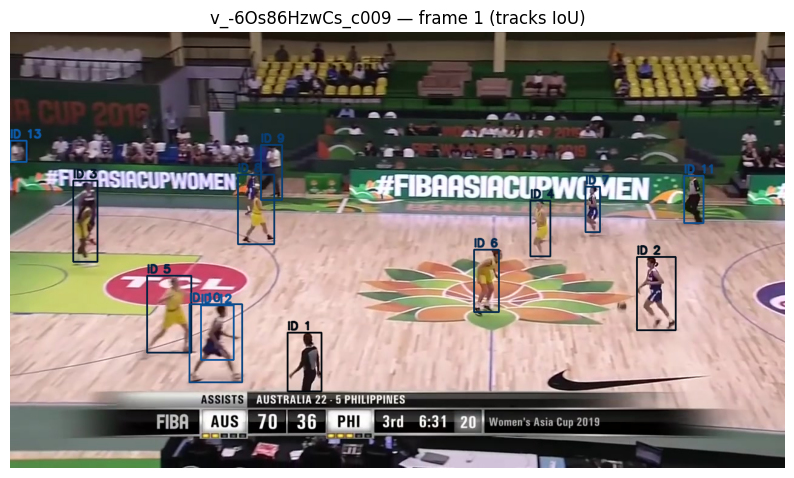

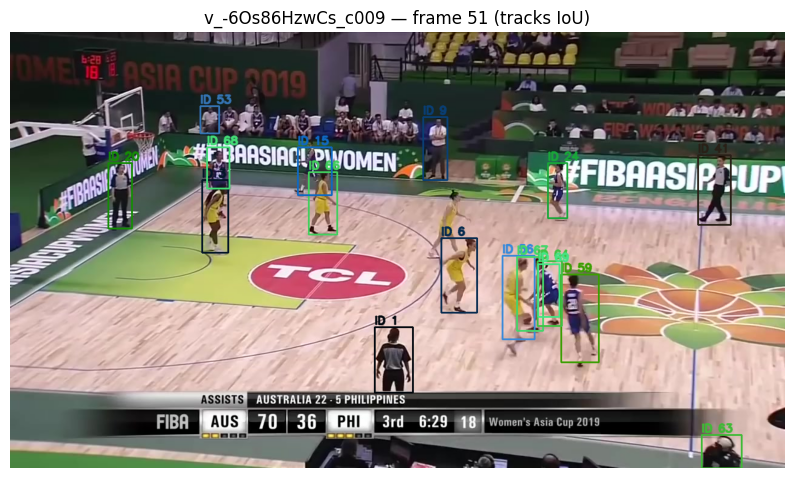

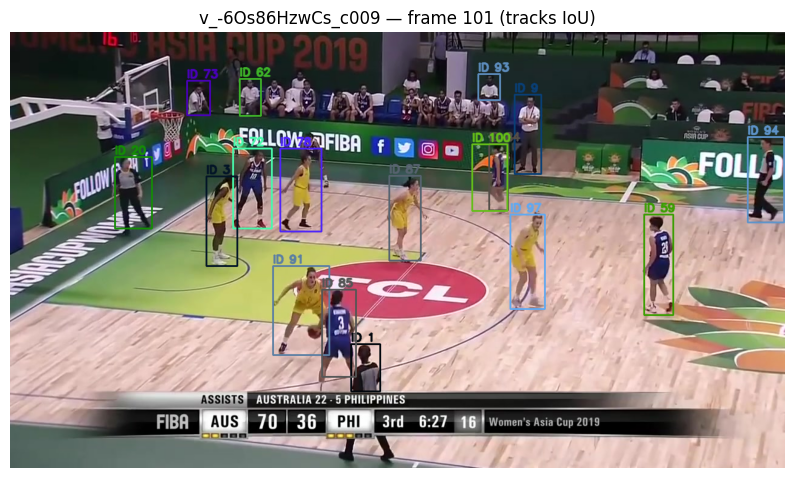

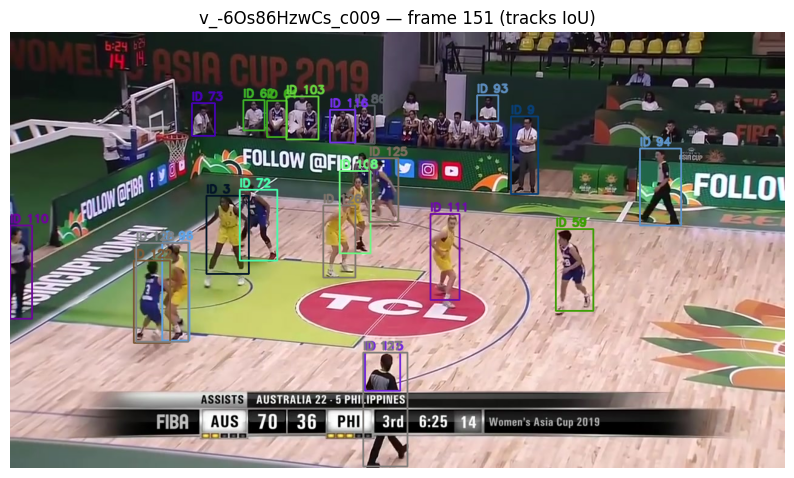

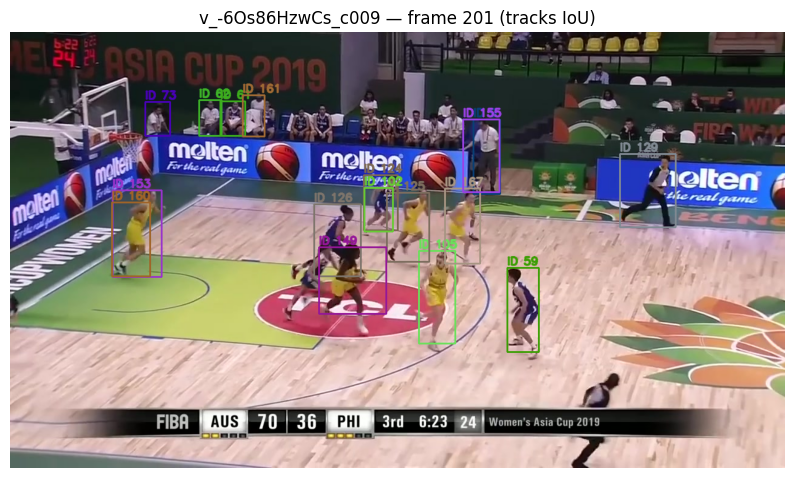

In [37]:
def visualize_tracks_on_frame(frame_path: Path,
                              tracks_df: pd.DataFrame,
                              max_tracks: int = 50):
    frame_id = int(frame_path.stem)
    img_bgr = cv2.imread(str(frame_path))
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    tr_f = tracks_df[tracks_df["frame"] == frame_id].copy()
    tr_f = tr_f.sort_values("conf", ascending=False).head(max_tracks)

    for _, row in tr_f.iterrows():
        x, y, w, h = row["x"], row["y"], row["w"], row["h"]
        tid = int(row["id"])

        # color pseudo-aleatorio por ID
        color = (
            hash(tid) % 255,
            hash(tid * 7) % 255,
            hash(tid * 13) % 255,
        )
        color = tuple(int(c) for c in color)

        cv2.rectangle(img, (int(x), int(y)),
                      (int(x + w), int(y + h)),
                      color, 2)
        cv2.putText(
            img,
            f"ID {tid}",
            (int(x), int(y) - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            color,
            2,
            cv2.LINE_AA,
        )

    plt.figure(figsize=(10, 7))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{seq_name} — frame {frame_id} (tracks IoU)")
    plt.show()


img_dir = SEQ_DIR / "img1"
all_frames = sorted(p for p in img_dir.iterdir() if p.suffix.lower() in (".jpg", ".png"))

# Visualizamos algunos frames espaciados
for fp in all_frames[::50][:5]:
    visualize_tracks_on_frame(fp, tracks_df)


## Animación: tracks del IoU tracker 🎥
Muestra los IDs asignados por el tracker IoU cuadro a cuadro.

In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from IPython.display import HTML


def animate_tracks(tracks_df, frame_paths, interval=80, max_tracks=50):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')

    def draw(idx):
        ax.clear()
        ax.axis('off')
        frame_path = frame_paths[idx]
        frame_id = int(frame_path.stem)
        img_bgr = cv2.imread(str(frame_path))
        if img_bgr is None:
            return []
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax.imshow(img)

        tr_f = tracks_df[tracks_df["frame"] == frame_id].copy()
        tr_f = tr_f.sort_values("conf", ascending=False).head(max_tracks)
        for _, row in tr_f.iterrows():
            x, y, w, h = row["x"], row["y"], row["w"], row["h"]
            tid = int(row.get("id", -1))
            ax.add_patch(Rectangle((x, y), w, h, linewidth=2, edgecolor='cyan', facecolor='none'))
            ax.text(x, y-2, f"ID {tid}", color='black', fontsize=8, bbox=dict(facecolor='cyan', alpha=0.4, pad=1))
        ax.set_title(f"Frame {frame_id} (IoU tracker)")
        return []

    anim = FuncAnimation(fig, draw, frames=len(frame_paths), interval=interval, blit=False)
    print('Generando animación de tracks (IoU)...')
    html_video = HTML(anim.to_jshtml())
    plt.close(fig)
    return html_video

frame_paths = sorted(img_dir.glob('*.jpg')) or sorted(img_dir.glob('*.png'))
frame_paths = frame_paths[:120]
if not frame_paths:
    raise FileNotFoundError(f'No se encontraron frames en {img_dir}')

video_animation = animate_tracks(tracks_df, frame_paths, interval=80)
video_animation
